produce another set of data for comparison purposes. 

Testing data

Separate script into training and histogramming?

CNN worked as aspected but work still needed to be done to address the accuracy.!!!!!!!!!!

# Next using actual data set(NEED TO FIND IT!)

Beta Cut PSDPara[1]<1.5

All waveform for Run009-230 -> SingleRun.root

Run009-230 histograms after beta cuts -> Standard_singrun.root

More than 3MeV events for Whole of Run009 after beta cuts -> beta_cut_15_dataset.root

Waveform of Events that are more 3MeV for whole of Run009 -> Run009_3Mev_waveform.root

# WIP, modify code into 3 separate sections, remake clock events


# Beta Cut PSDPara[1]<1.5

# All waveform for Run009-230 -> SingleRun.root
DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&0x4)!=0
# Run009-230 histograms after beta cuts -> Standard_singrun.root
PSDPara[1]<1.5 && DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&0x4)!=0
# More than 3MeV events for Whole of Run009 after beta cuts -> beta_cut_15_dataset.root
Energy[1]>3000 && PSDPara[1]<1.5 && DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&0x4)!=0
# Waveform of Events that are more 3MeV for whole of Run009 -> Run009_3Mev_waveform.root
Energy[1]>3000 && DataQuality[0]==0 && DataQuality[1]==0 && DataQuality[2]==0 && DataQuality[3]==0 && CrystalN[0]!=0 && ((TriggerCounter[33]|TriggerCounter[36])&0x4)!=0

# Definations and python imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from root_pandas import read_root
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 10.0, 8.0

file_piled = "Piled_2.root"
# file_flat = "Flat.root"
# file_alpha = "Alpha_11.root"
file_ls = "LS.root"
file_ls_beta = "LS_BETA.root"
file_ref = "RefPulse009.root"

file_230_waveform = "SingleRun.root"
file_230_energy = "Standard_singrun.root"
file_009_energy = "beta_cut_15_dataset.root"
file_009_waveform = "Run009_3Mev_waveform.root"

data = "PMTALL"
tree = "tree"

pmt_all_length = 4480

def NORM(file, tree, data):
    pmtall = read_root(file, tree, columns=[data],flatten=[data])
    num_entries, w = pmtall.shape
    num_entries = int(num_entries/pmt_all_length)
    x = pmtall.PMTALL.values.reshape(num_entries, pmt_all_length)
    x_abs = abs(x - 15200)
    extra = np.arange(4160, pmt_all_length)
    x_mod = np.delete(x_abs, extra, axis=1)
    x_nor = normalize(x_mod, norm="l1")
    return x_nor

def differ(x,y):
    for i in range(len(x)):
        x[i] = x[i] - y
    return x

def sep(x, ratio_1, ratio_2, ratio_3, group):
    train = np.zeros((int(len(x)*ratio_1), len(x[0])))
    validation = np.zeros((int(len(x)*ratio_2),len(x[0])))
    test = np.zeros((int(len(x)*ratio_3), len(x[0])))
    for i in range(len(x)):
        if i < int(len(x)*ratio_1):
            train[i] = x[i]
            
        if i >= int(len(x)*ratio_1) and i < int(len(x)*(ratio_2 +ratio_1)):
            k = i - int(len(x)*ratio_1) - 1
            validation[k] = x[i]
            
        if i >= int(len(x)*(ratio_1 + ratio_2)):
            p = i - int(len(x)*(ratio_1 + ratio_2)) - 1
            test[p] = x[i]
        
    train_label = np.zeros(len(train))
    validation_label = np.zeros(len(validation))
    test_label = np.zeros(len(test))
    for i in range(len(train)):
        train_label[i] = group
    for i in range(len(validation)):
        validation_label[i] = group
    for i in range(len(test)):
        test_label[i] = group
    return train, validation, test, train_label, validation_label, test_label

import keras
def data_for_cnn(x1, x2, x3, x4, x5, group):
    x11, x12, x13, x14, x15, x16 = x1
    x21, x22, x23, x24, x25, x26 = x2
    x31, x32, x33, x34, x35, x36 = x3
    x41, x42, x43, x44, x45, x46 = x4
    x51, x52, x53, x54, x55, x56 = x5
#     x61, x62, x63, x64, x65, x66 = x6
    y1 = np.concatenate((x11, x21, x31, x41, x51), axis=0)
    y2 = np.concatenate((x12, x22, x32, x42, x52), axis=0)
    y3 = np.concatenate((x13, x23, x33, x43, x53), axis=0)
    y4 = np.concatenate((x14, x24, x34, x44, x54), axis=0)
    y5 = np.concatenate((x15, x25, x35, x45, x55), axis=0)
    y6 = np.concatenate((x16, x26, x36, x46, x56), axis=0)
    z1 = np.expand_dims(y1, axis=2)
    z2 = np.expand_dims(y2, axis=2)
    z3 = np.expand_dims(y3, axis=2)
    z4 = keras.utils.to_categorical(y4, group)
    z5 = keras.utils.to_categorical(y5, group)
    z6 = keras.utils.to_categorical(y6, group)
    return z1, z2, z3, z4, z5, z6

Welcome to JupyROOT 6.10/08


Using TensorFlow backend.
/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Preparing Trainining data

In [2]:
%%time
def art1():
    x = np.arange(0,1,0.00025)
    y2 = np.zeros(len(x))
    
    start = np.random.rand(1)*0.02 + 0.1
    sepa = np.random.rand(1)*0.4 + 0.1
    first = np.random.rand(1)*0.1 + 0.9
    mult = np.random.rand(1)
    second = first+mult*first

    fdeca = np.random.rand(1)*5 + 95
    sdeca = np.random.rand(1)*5 + 95
    for i in range(len(x)):
        if i < int(start*len(x)):
            y2[i] = 0.1
        if i >= int(start*len(x)) and i < int(sepa*len(x)):
            y2[i] = first*np.exp(-(x[i]-start)*fdeca) + 0.1
        if i >= int(sepa*len(x)):
            y2[i] = second*np.exp(-(x[i]-sepa)*sdeca) + 0.1
    
    stop = 0.25 + np.random.rand(1)*0.05
    for i in range(len(x)):
        if i< int(start*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.02 - 0.01
        if i >= int(start*len(x)) and i < int(stop*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.1 - 0.05
        if i >= int(stop*len(x)):
            y2[i] = y2[i] + np.random.rand(1)*0.005 - 0.0025 
    
    ex = np.zeros(160)
    for i in range(160):
        ex[i] = np.random.rand(1)*0.005 - 0.0025 + 0.1
    y2 = np.concatenate((y2,ex),axis=0)
    return y2

def art2():
    x = np.arange(0,1,0.00025)
    y3 = np.zeros(len(x))
    start = np.random.rand(1)*0.02 + 0.1
    sepa = np.random.rand(1)*0.4 + 0.1
    first = np.random.rand(1)*0.1 + 0.9
    mult = np.random.rand(1)
    second = first+mult*first
    
    fslow = np.random.rand(1)*2 + 10 
    sslow = np.random.rand(1)*2 + 10

    y3 = np.zeros(len(x))
    for i in range(len(x)):
        if i < int(start*len(x)):
            y3[i] = 0.1
        if i >= int(start*len(x)) and i < int(sepa*len(x)):
            y3[i] = first*np.exp(-(x[i]-start)*fslow) + 0.1
        if i >= int(sepa*len(x)):
            y3[i] = second*np.exp(-(x[i]-sepa)*sslow) + 0.1 
    
    stop = 0.25 + np.random.rand(1)*0.05
    for i in range(len(x)):
        if i< int(start*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.02 - 0.01
        if i >= int(start*len(x)) and i < int(stop*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.1 - 0.05
        if i >= int(stop*len(x)):
            y3[i] = y3[i] + np.random.rand(1)*0.005 - 0.0025
    
    ex = np.zeros(160)
    for i in range(160):
        ex[i] = np.random.rand(1)*0.005 - 0.0025 + 0.1
    y3 = np.concatenate((y3,ex),axis=0)
    return y3

print(art1().shape)
artificial = np.zeros((4000,4160))

for i in range(4000):
    if i <2000:
        artificial[i] = art1()
    if i >=2000:
        artificial[i] = art2()
print(artificial.shape)


(4160,)
(4000, 4160)
CPU times: user 3min 53s, sys: 11.1 s, total: 4min 4s
Wall time: 3min 44s


In [3]:
%%time

ratio_1 = 0.6
ratio_2 = 0.2
ratio_3 = 0.2

print("Number of entries")

# PMTALL_alpha = NORM(file_alpha, tree, data)
# print("PMTALL_alpha :",len(PMTALL_alpha))
# alpha = sep(PMTALL_alpha, ratio_1, ratio_2, ratio_3, 0)
# del PMTALL_alpha

PMTALL_ref = NORM(file_ref, tree, data)
print("PMTALL_ref :",len(PMTALL_ref))
ref = sep(PMTALL_ref, ratio_1, ratio_2, ratio_3, 1)
del PMTALL_ref

PMTALL_piled = NORM(file_piled, tree, data)
print("PMTALL_piled :",len(PMTALL_piled))
piled = sep(PMTALL_piled, ratio_1, ratio_2, ratio_3, 0)
del PMTALL_piled

# PMTALL_flat = NORM(file_flat, tree, data)
# print("PMTALL_flat :",len(PMTALL_flat))
# flat = sep(PMTALL_flat, ratio_1, ratio_2, ratio_3, 3)
# del PMTALL_flat

PMTALL_ls = NORM(file_ls, tree, data)
print("PMTALL_ls :",len(PMTALL_ls))
ls = sep(PMTALL_ls, ratio_1, ratio_2, ratio_3, 2)
del PMTALL_ls

PMTALL_ls_beta = NORM(file_ls_beta, tree, data)
print("PMTALL_ls_beta :",len(PMTALL_ls_beta))
ls_beta = sep(PMTALL_ls_beta, ratio_1, ratio_2, ratio_3, 3)
del PMTALL_ls_beta

print("Artificial data:",len(artificial))
fake = sep(artificial, ratio_1, ratio_2, ratio_3, 0)
del artificial

classes = 4
train_data, validation_data, test_data, train_label, validation_label, test_label = data_for_cnn(piled, ls, ls_beta, ref, fake, classes)

del piled, ls, ls_beta, ref, fake

Number of entries
PMTALL_ref : 2014
PMTALL_piled : 2073
PMTALL_ls : 16908
PMTALL_ls_beta : 19293
Artificial data: 4000
CPU times: user 9.85 s, sys: 3.13 s, total: 13 s
Wall time: 13.8 s


# 4096 input channels? 2^12

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 4145, 16)          272       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2072, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 2057, 32)          8224      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 514, 32)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 514, 64)           2112      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 64, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

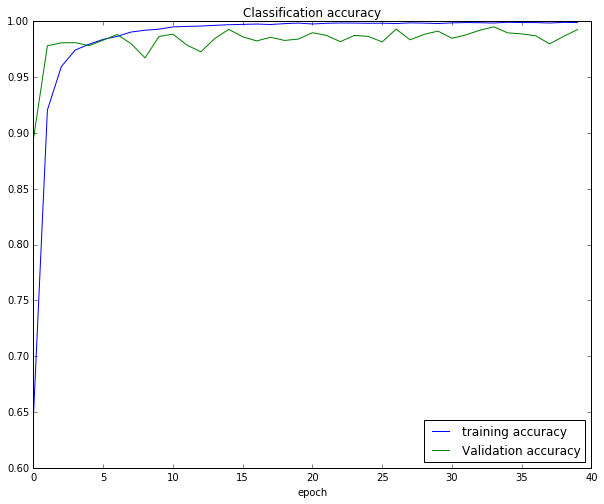

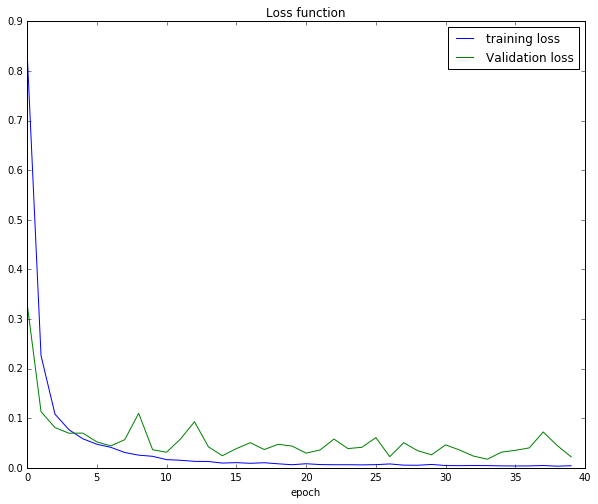

Classification accuracy = 0.992659514668
CPU times: user 6h 21min 22s, sys: 28min 7s, total: 6h 49min 30s
Wall time: 1h 5min 19s


In [5]:
%%time
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Activation, Conv1D, MaxPooling1D, Dropout, Flatten, BatchNormalization, Embedding, LSTM

from keras.regularizers import l2
from keras.optimizers import SGD

model = Sequential()
model.add(Conv1D(16, kernel_size=16, activation="relu", input_shape=(len(train_data[0]),1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, 16, activation="relu"))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(64, 1, activation="relu"))
model.add(MaxPooling1D(pool_size=8))
# model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
# model.add(Dense(32,activation="relu"))
# model.add(Dense(16,activation="relu"))
# model.add(Dense(8,activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(classes,activation="softmax"))
model.summary()
model.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.Adadelta(), metrics=['accuracy'])
history = model.fit(train_data, train_label, batch_size=200, epochs=40, verbose=1, validation_data=(validation_data, validation_label))
score = model.evaluate(test_data, test_label, verbose=0)
model.save("CNN_d.h5")

del train_data,train_label,validation_data,validation_label,test_data,test_label

print('Test loss:', score[0])
print('Test accuracy:', score[1])

print(history.history.keys())
plt.figure()
plt.title("Classification accuracy")
plt.xlabel("epoch")
plt.plot(history.history['acc'],label="training accuracy")
plt.plot(history.history['val_acc'],label="Validation accuracy")
plt.legend(loc=4)
plt.show()

plt.figure()
plt.title("Loss function")
plt.xlabel("epoch")
plt.plot(history.history['loss'],label="training loss")
plt.plot(history.history['val_loss'],label="Validation loss")
plt.legend()
plt.show()

print("Classification accuracy =",history.history['val_acc'][-1])